In [1]:
import os
import numpy as np
from edpyt.espace import build_espace, screen_espace
from edpyt.gf2_lanczos import build_gf2_lanczos
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize
import os
import matplotlib.pyplot as plt
new_path = '/capstor/scratch/cscs/ajayaraj/qtpyt-tests/pentadienyl'
os.chdir(new_path)

/users/ajayaraj/miniconda3/envs/qtpyt/lib/python3.9/site-packages/numba/cpython/hashing.py:524: UserWarning: FNV hashing is not implemented in Numba. See PEP 456 https://www.python.org/dev/peps/pep-0456/ for rationale over not using FNV. Numba will continue to work, but hashes for built in types will be computed using siphash24. This will permit e.g. dictionaries to continue to behave as expected, however anything relying on the value of the hash opposed to hash as a derived property is likely to not work as expected.
  warnings.warn(msg)


In [2]:
class Sigma:
    def __init__(self, gf, H_eff, mu = 0.0, eta=1e-5):
        self.gf = gf
        self.eta = eta
        self.H_eff = H_eff
        self.mu = mu

    def retarded(self, energy):
        energies = np.atleast_1d(energy)
        g = self.gf(energies, self.eta)
        sigma = np.empty((energies.size, self.gf.n, self.gf.n), complex)
        for e, energy in enumerate(energies):
            sigma[e] = energy + self.mu - self.H_eff - np.linalg.inv(g[..., e])
        return sigma

In [3]:
# === Load inputs ===
input_folder = "output/lowdin"
output_folder = "output/lowdin/beta_1000/ed"
os.makedirs(output_folder, exist_ok=True)

H_eff = np.load(f"{input_folder}/effective_hamiltonian.npy")
occupancy_goal = np.load(f"{input_folder}/beta_1000/occupancies.npy")
V = np.loadtxt(f"{input_folder}/U_matrix.txt")

# === Parameters ===
nimp = H_eff.shape[0]
eta = 1e-3
beta = 1000

# === Initial double counting ===
DC0 = np.diag(V.diagonal() * (occupancy_goal - 0.5))
neig = np.ones((nimp + 1) * (nimp + 1), int) * 6


In [4]:
plot_counter = 0
fig_dir = os.path.join(output_folder, "figures")
os.makedirs(fig_dir, exist_ok=True)
energies_plot = np.arange(-20, 18, 0.1)


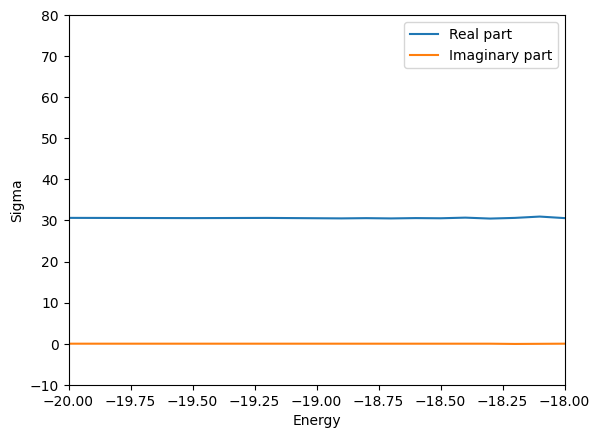

In [5]:
espace, egs = build_espace(H_eff - DC0, V, neig_sector=neig)
screen_espace(espace, egs, beta)

gf = build_gf2_lanczos(H_eff - DC0, V, espace, beta, egs)
sigma = Sigma(gf, H_eff, eta=eta)
sigma_ret = sigma.retarded(energies_plot)
sigma_ret_trace = np.trace(sigma_ret, axis1=1, axis2=2)

plt.plot(energies_plot, sigma_ret_trace.real, label="Real part")
plt.plot(energies_plot, sigma_ret_trace.imag, label="Imaginary part")
plt.xlabel("Energy")
plt.ylabel("Sigma")
plt.xlim(-20, -18)
plt.ylim(-10,80)
plt.legend()
plt.show()

### Broyden mixing

In [8]:
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.optimize import broyden1

class Converged(Exception):
    pass

# Adjustable penalty weight
penalty_weight = 5.0  # Increase for stronger constraint enforcement
delta_order = 0.01    # Minimum required margin between DC[0]/DC[6] and others

# Precompute reference ratio structure
dc0_diag = DC0.diagonal()
target_ratios = dc0_diag / np.max(dc0_diag)

plot_counter = 0
fig_dir = os.path.join(output_folder, "figures")
os.makedirs(fig_dir, exist_ok=True)
energies_plot = np.arange(-20, 20.1, 0.1)

def residual_function(dc_diag):
    global plot_counter

    # Main physics part
    DC = np.diag(dc_diag)
    espace, egs = build_espace(H_eff - DC, V, neig_sector=neig)
    screen_espace(espace, egs, beta)
    gf = build_gf2_lanczos(H_eff - DC, V, espace, beta, egs)
    sigma = Sigma(gf, H_eff, eta=eta)

    # Get residual from Sigma at large negative frequency
    energies = np.array([-1000])
    sig_cost = sigma.retarded(energies)  # (2, nimp, nimp)
    sig_real_diag = sig_cost.real.diagonal(axis1=1, axis2=2)
    residual = np.mean(sig_real_diag, axis=0)

    # ------------------
    # Constraint Penalties
    # ------------------

    # 1. Ordering penalty: DC[0] and DC[6] should be strictly largest
    order_penalty = np.zeros_like(residual)

    others = np.delete(dc_diag, [0, 6])
    if not dc_diag[0] >= np.max(others) + delta_order:
        order_penalty[0] += penalty_weight * (np.max(others) + delta_order - dc_diag[0])
    if not dc_diag[6] >= np.max(np.delete(dc_diag, [0])) + delta_order:
        order_penalty[6] += penalty_weight * (np.max(np.delete(dc_diag, [0])) + delta_order - dc_diag[6])

    # 2. Ratio penalty: Match normalized ratios of DC0
    current_ratios = dc_diag / np.max(dc_diag)
    ratio_penalty = penalty_weight * (current_ratios - target_ratios)

    # Combine penalties with the original residual
    total_residual = residual + order_penalty + ratio_penalty

    # ------------------
    # Plot Σ trace
    # ------------------
    residual_norm = np.linalg.norm(total_residual)
    print(f"[Broyden] Residual norm: {residual_norm:.6e}, DC_diag: {dc_diag}")

    sig_plot = sigma.retarded(energies_plot)
    trace_real = np.trace(sig_plot.real, axis1=1, axis2=2)
    trace_imag = np.trace(sig_plot.imag, axis1=1, axis2=2)

    plt.figure(figsize=(6, 4))
    plt.plot(energies_plot, trace_real, label="Re Tr Σ(ω)", linestyle="-")
    plt.plot(energies_plot, trace_imag, label="Im Tr Σ(ω)", linestyle="--")
    plt.xlabel("Energy (eV)")
    plt.ylabel("Tr Σ(ω)")
    plt.title(f"Σ Trace – Eval {plot_counter}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    fig_path = os.path.join(fig_dir, f"sigma_trace_eval_{plot_counter:03d}.png")
    plt.savefig(fig_path, dpi=100)
    plt.close()
    plot_counter += 1

    # Stop early if physically meaningful convergence is reached
    if residual_norm < 1e-3:
        raise Converged()

    return total_residual


# Initial guess
x0 = dc0_diag.copy()

try:
    dc_diag_optimized = broyden1(
        residual_function,
        x0,
        f_tol=1e-3,
        maxiter=50,
        verbose=True,
    )
except Converged:
    dc_diag_optimized = x0  # Updated in-place
    print("Converged early based on residual norm threshold and structure guidance.")


[Broyden] Residual norm: 1.271221e+01, DC_diag: [5.46515887 1.97886514 2.52035611 2.22202704 2.7152016  2.12250731
 5.90703705]
[Broyden] Residual norm: 1.595724e+01, DC_diag: [5.96612106 4.07662826 4.4633105  4.28224377 4.69600461 4.53466985
 6.64712568]
[Broyden] Residual norm: 1.228957e+01, DC_diag: [5.62412384 2.64452584 3.13689301 2.87577355 3.3437486  2.88793301
 6.14188145]
0:  |F(x)| = 6.19271; step 0.317319
[Broyden] Residual norm: 1.118119e+02, DC_diag: [ 8.31468485 21.9387646  21.23252893 22.21547189 21.81258099 25.09777866
 11.05784157]
[Broyden] Residual norm: 1.222368e+01, DC_diag: [5.64037596 2.76107117 3.24619828 2.99259347 3.45530813 3.02208983
 6.17157592]
1:  |F(x)| = 6.157; step 0.00604042
[Broyden] Residual norm: 1.367823e+02, DC_diag: [ 7.18268327 24.05303496 23.67594993 24.93033771 24.35331078 27.52953392
 10.24881876]
[Broyden] Residual norm: 1.218164e+01, DC_diag: [5.6465346  2.84609289 3.32777707 3.08019388 3.53875671 3.11995141
 6.18785691]
2:  |F(x)| = 6.132

KeyboardInterrupt: 

In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.optimize import broyden1

class Converged(Exception):
    pass

# Penalty tuning
penalty_weight = 1.0      # Less aggressive than before
delta_order = 0.01        # Minimum margin for ordering (eV)
dc_diag_clip_bounds = (2.0, 10.0)  # Prevent unphysical values

# Precompute reference ratio structure
dc0_diag = DC0.diagonal()
target_ratios = dc0_diag / np.max(dc0_diag)

plot_counter = 0
fig_dir = os.path.join(output_folder, "figures")
os.makedirs(fig_dir, exist_ok=True)
energies_plot = np.arange(-20, 20.1, 0.1)

def residual_function(dc_diag):
    global plot_counter

    # Clip unphysical values
    dc_diag = np.clip(dc_diag, *dc_diag_clip_bounds)

    # Main physics calculation
    DC = np.diag(dc_diag)
    espace, egs = build_espace(H_eff - DC, V, neig_sector=neig)
    screen_espace(espace, egs, beta)
    gf = build_gf2_lanczos(H_eff - DC, V, espace, beta, egs)
    sigma = Sigma(gf, H_eff, eta=eta)

    # Get physical residual from Σ at large negative frequency
    energies = np.array([-1000])
    sig_cost = sigma.retarded(energies)  # (2, nimp, nimp)
    sig_real_diag = sig_cost.real.diagonal(axis1=1, axis2=2)
    residual = np.mean(sig_real_diag, axis=0)

    # -----------------------------------
    # Penalty terms for structure control
    # -----------------------------------

    # 1. Ordering penalty
    order_penalty = np.zeros_like(residual)
    others = np.delete(dc_diag, [0, 6])
    if dc_diag[0] < np.max(others) + delta_order:
        order_penalty[0] += penalty_weight * (np.max(others) + delta_order - dc_diag[0])
    if dc_diag[6] < np.max(np.delete(dc_diag, [0])) + delta_order:
        order_penalty[6] += penalty_weight * (np.max(np.delete(dc_diag, [0])) + delta_order - dc_diag[6])

    # 2. Ratio penalty (safe log scale)
    dc_diag_max = np.max(dc_diag) if np.max(dc_diag) > 1e-8 else 1.0
    current_ratios = dc_diag / dc_diag_max
    ratio_penalty = penalty_weight * (np.log1p(current_ratios) - np.log1p(target_ratios))

    # Combine all into total residual
    total_residual = residual + order_penalty + ratio_penalty

    # -----------------------------------
    # Logging and plotting
    # -----------------------------------
    residual_norm = np.linalg.norm(total_residual)
    print(f"[Broyden] Residual norm: {residual_norm:.6e}, DC_diag: {dc_diag}")
    print(f"Penalty | Order: {np.linalg.norm(order_penalty):.3e}, Ratio: {np.linalg.norm(ratio_penalty):.3e}")

    # Plot Σ trace
    sig_plot = sigma.retarded(energies_plot)
    trace_real = np.trace(sig_plot.real, axis1=1, axis2=2)
    trace_imag = np.trace(sig_plot.imag, axis1=1, axis2=2)

    plt.figure(figsize=(6, 4))
    plt.plot(energies_plot, trace_real, label="Re Tr Σ(ω)", linestyle="-")
    plt.plot(energies_plot, trace_imag, label="Im Tr Σ(ω)", linestyle="--")
    plt.xlabel("Energy (eV)")
    plt.ylabel("Tr Σ(ω)")
    plt.title(f"Σ Trace – Eval {plot_counter}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    fig_path = os.path.join(fig_dir, f"sigma_trace_eval_{plot_counter:03d}.png")
    plt.savefig(fig_path, dpi=100)
    plt.close()
    plot_counter += 1

    # Early stop if convergence met
    if residual_norm < 1e-3:
        raise Converged()

    return total_residual


# Initial guess
x0 = dc0_diag.copy()

try:
    dc_diag_optimized = broyden1(
        residual_function,
        x0,
        f_tol=1e-3,
        maxiter=50,
        verbose=True,
    )
except Converged:
    dc_diag_optimized = x0  # Updated in-place
    print("Converged early based on residual norm threshold and structure guidance.")


[Broyden] Residual norm: 1.270610e+01, DC_diag: [5.46515887 1.97886514 2.52035611 2.22202704 2.7152016  2.12250731
 5.90703705]
Penalty | Order: 1.000e-02, Ratio: 0.000e+00
[Broyden] Residual norm: 1.339121e+01, DC_diag: [5.96636222 4.0776381  4.46424581 4.28323553 4.69695815 4.53583104
 6.63239703]
Penalty | Order: 1.000e-02, Ratio: 4.054e-01
[Broyden] Residual norm: 1.085039e+01, DC_diag: [5.6907741  2.92362169 3.39539241 3.14987405 3.60728355 3.20885797
 6.23355574]
Penalty | Order: 1.000e-02, Ratio: 2.035e-01
0:  |F(x)| = 5.4277; step 0.450147
[Broyden] Residual norm: 1.039730e+01, DC_diag: [6.88538062 8.37771721 8.58464055 8.66264604 8.91489089 9.46412232
 8.03545522]
Penalty | Order: 2.962e+00, Ratio: 7.491e-01
1:  |F(x)| = 4.83085; step 1
[Broyden] Residual norm: 9.758072e+00, DC_diag: [10. 10. 10. 10. 10. 10. 10.]
Penalty | Order: 1.414e-02, Ratio: 8.167e-01
2:  |F(x)| = 4.79037; step 1
[Broyden] Residual norm: 1.559033e+01, DC_diag: [0. 0. 0. 0. 0. 0. 0.]
Penalty | Order: 1.41

KeyboardInterrupt: 